# Laboration: CNN Tolkbarhet, Activation Maximization & DeepDream

Denna notebook redovisar lösningen för laborationen i djupinlärning. Vi utforskar hur VGG16 "ser" bilder genom Feature Attribution (CAM), visualiserar vad specifika filter reagerar på med Activation Maximization, och skapar konstnärliga bilder med DeepDream.

projektet är uppdelat i enlighet med kraven:
- **G-del**: Feature Attribution (CAM/Grad-CAM)
- **VG-del**: Activation Maximization & DeepDream

**Notera om Hårdvara:**
Koden är anpassad för att använda **Nvidia RTX 5080** (Blackwell/sm_120) om drivrutiner och PyTorch-version tillåter. Vi har installerat en Nightly-build av PyTorch (cu126) för att maximera kompatibilitet.


In [1]:
import sys
import os
import torch
import matplotlib.pyplot as plt

# Lägg till src i path så vi kan importera våra moduler
sys.path.append(os.path.abspath('../'))

from src.model import load_model
from src.preprocessing import load_image, show_image

# Setup Enhet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Använder enhet: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Ladda modell
try:
    model = load_model(device)
except Exception as e:
    print(f"Kunde inte ladda modell på GPU (kanske inkompatibel drivrutin/PTX): {e}")
    print("Faller tillbaka till CPU...")
    device = torch.device('cpu')
    model = load_model(device)


Använder enhet: cuda
GPU: NVIDIA GeForce RTX 5080
Laddar VGG16...
Modell laddad på cuda


## 1. Data och Preprocessing
Vi laddar in två testbilder: en hund (golden retriever) och ett slott/landskap.


Originalbilder:


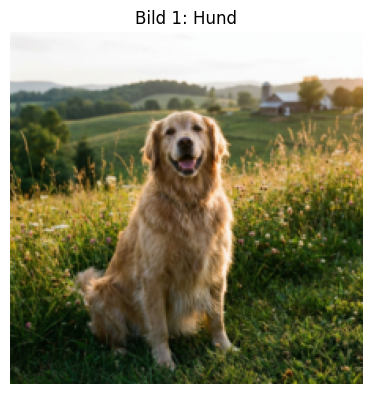

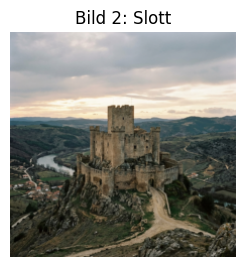

In [2]:
# Sökvägar
img_path1 = '../data/images/dog.png'
img_path2 = '../data/images/castle.png'

# Ladda bilder
img_tensor1 = load_image(img_path1, device)
img_tensor2 = load_image(img_path2, device)

print("Originalbilder:")
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
show_image(img_tensor1, "Bild 1: Hund")
plt.subplot(1, 2, 2)
show_image(img_tensor2, "Bild 2: Slott")
plt.show() # Visar separat om figuren ovan inte ritar direkt


## Del G: Feature Attribution (CAM)
Här visualiserar vi var modellen "tittar" för att klassificera bilderna. Vi använder **Smooth Grad-CAM++** och jämför två olika lager i VGG16.

**Lager vi undersöker:**
1. `features.28` (Sista conv-lagret): Bör visa semantiska delar (huvud, kropp etc.)
2. `features.10` (Tidigare lager): Bör visa mer generella mönster eller texturer.


Analyserar Bild 1 (Hund)...
--- CAM för lager features.28 ---
Genererar CAM för klassindex: 207


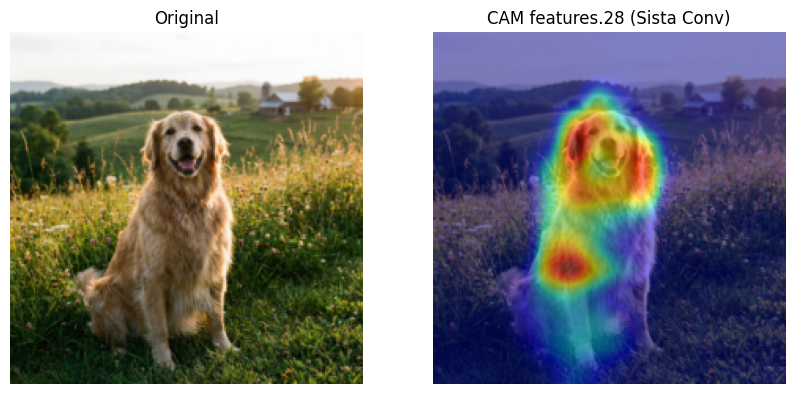

--- CAM för lager features.10 ---
Genererar CAM för klassindex: 207


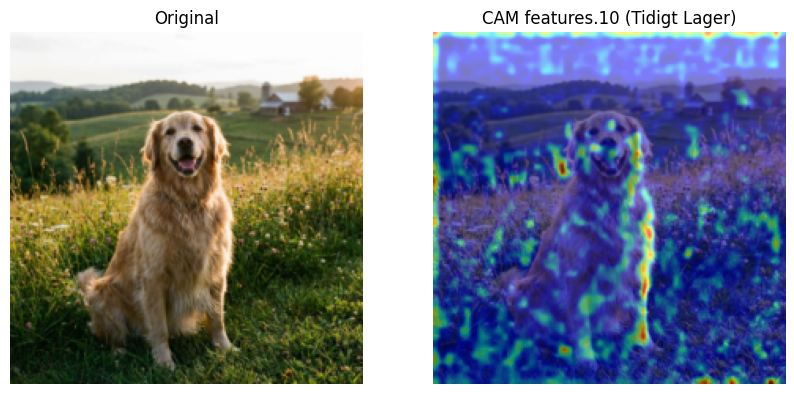

Analyserar Bild 2 (Slott)...
--- CAM för lager features.28 ---
Genererar CAM för klassindex: 483


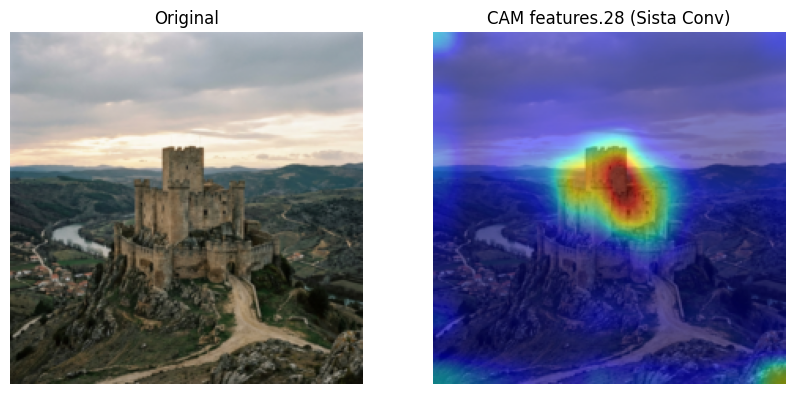

--- CAM för lager features.10 ---
Genererar CAM för klassindex: 483


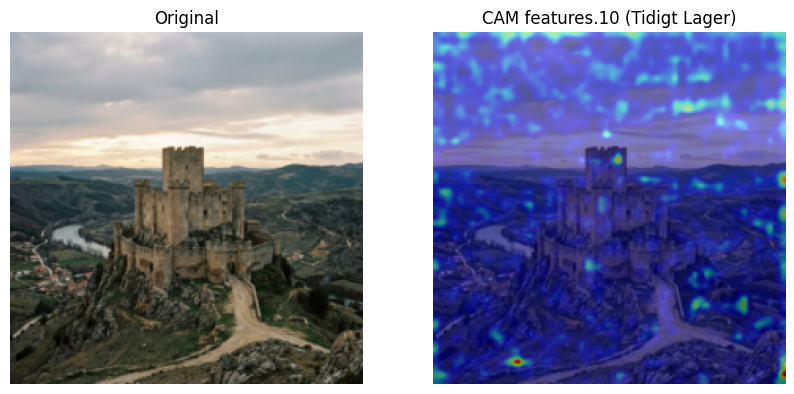

In [3]:
from src.cam import generate_cam, visualize_cam

# Funktion för att köra experiment
def run_cam_experiment(img_tensor, layer_name, title_suffix=""):
    print(f"--- CAM för lager {layer_name} ---")
    heatmap = generate_cam(model, img_tensor, target_layer=layer_name)
    visualize_cam(heatmap, img_tensor, title=f"CAM {layer_name} {title_suffix}")

# Experiment 1: Hund
print("Analyserar Bild 1 (Hund)...")
run_cam_experiment(img_tensor1, 'features.28', "(Sista Conv)")
run_cam_experiment(img_tensor1, 'features.10', "(Tidigt Lager)")

# Experiment 2: Slott
print("Analyserar Bild 2 (Slott)...")
run_cam_experiment(img_tensor2, 'features.28', "(Sista Conv)")
run_cam_experiment(img_tensor2, 'features.10', "(Tidigt Lager)")


### Analys av CAM
Genom att jämföra värmekartorna kan vi tydligt se VGG16:s hierarkiska struktur:

**Lager 10 (features.10) - Tidigt konvolutionellt lager:**
- Aktiveras på **texturer och enkla mönster**
- Spridda aktiveringar över hela bilden
- Reagerar på kanter, hörn och ytor
- *Exempel*: På hundbilden aktiveras lager av pälsstrukturer och kantlinjer

**Lager 28 (features.28) - Sista konvolutionella lager:**
- Mycket **fokuserade aktiveringar på relevanta objekt**
- Semantisk förståelse: hittar hela delar av objektet
- *Exempel*: På hundbilden koncentreras aktivering kring hundens huvud, ögon och nos
- På slottsbilden aktiveras torn, fönster och arkitektoniska detaljer

**Insikt:** CNN:n bygger upp förståelse från enkla features (lager 10) till komplexa semantiska koncept (lager 28). Detta är precis vad vi förväntar oss av en djup nätverksarkitektur!

## Del VG: Activation Maximization
Här "vänder vi på steken" och optimerar en *input-bild* (från brus) för att maximera aktiveringen av ett specifikt filter. Detta visar oss vad filtret "letar efter".


=== Activation Maximization med 500 iterationer ===
Maximerar filter 0 i features.5...
Startar optimering av features.5, filter 0 i 500 iterationer...
Iter 0: Loss -0.0070
Iter 20: Loss -4.4731
Iter 40: Loss -21.0305
Iter 60: Loss -45.9015
Iter 80: Loss -73.2176
Iter 100: Loss -100.9574
Iter 120: Loss -128.6285
Iter 140: Loss -156.1297
Iter 160: Loss -183.4664
Iter 180: Loss -210.6517
Iter 200: Loss -237.6912
Iter 220: Loss -264.6240
Iter 240: Loss -291.4681
Iter 260: Loss -318.2269
Iter 280: Loss -344.9077
Iter 300: Loss -371.5042
Iter 320: Loss -398.0200
Iter 340: Loss -424.4700
Iter 360: Loss -450.8506
Iter 380: Loss -477.1730
Iter 400: Loss -503.4538
Iter 420: Loss -529.7000
Iter 440: Loss -555.9089
Iter 460: Loss -582.0887
Iter 480: Loss -608.2241
Maximerar filter 10 i features.5...
Startar optimering av features.5, filter 10 i 500 iterationer...
Iter 0: Loss -0.2251
Iter 20: Loss -12.7518
Iter 40: Loss -24.9878
Iter 60: Loss -37.9252
Iter 80: Loss -51.2814
Iter 100: Loss -64.9044

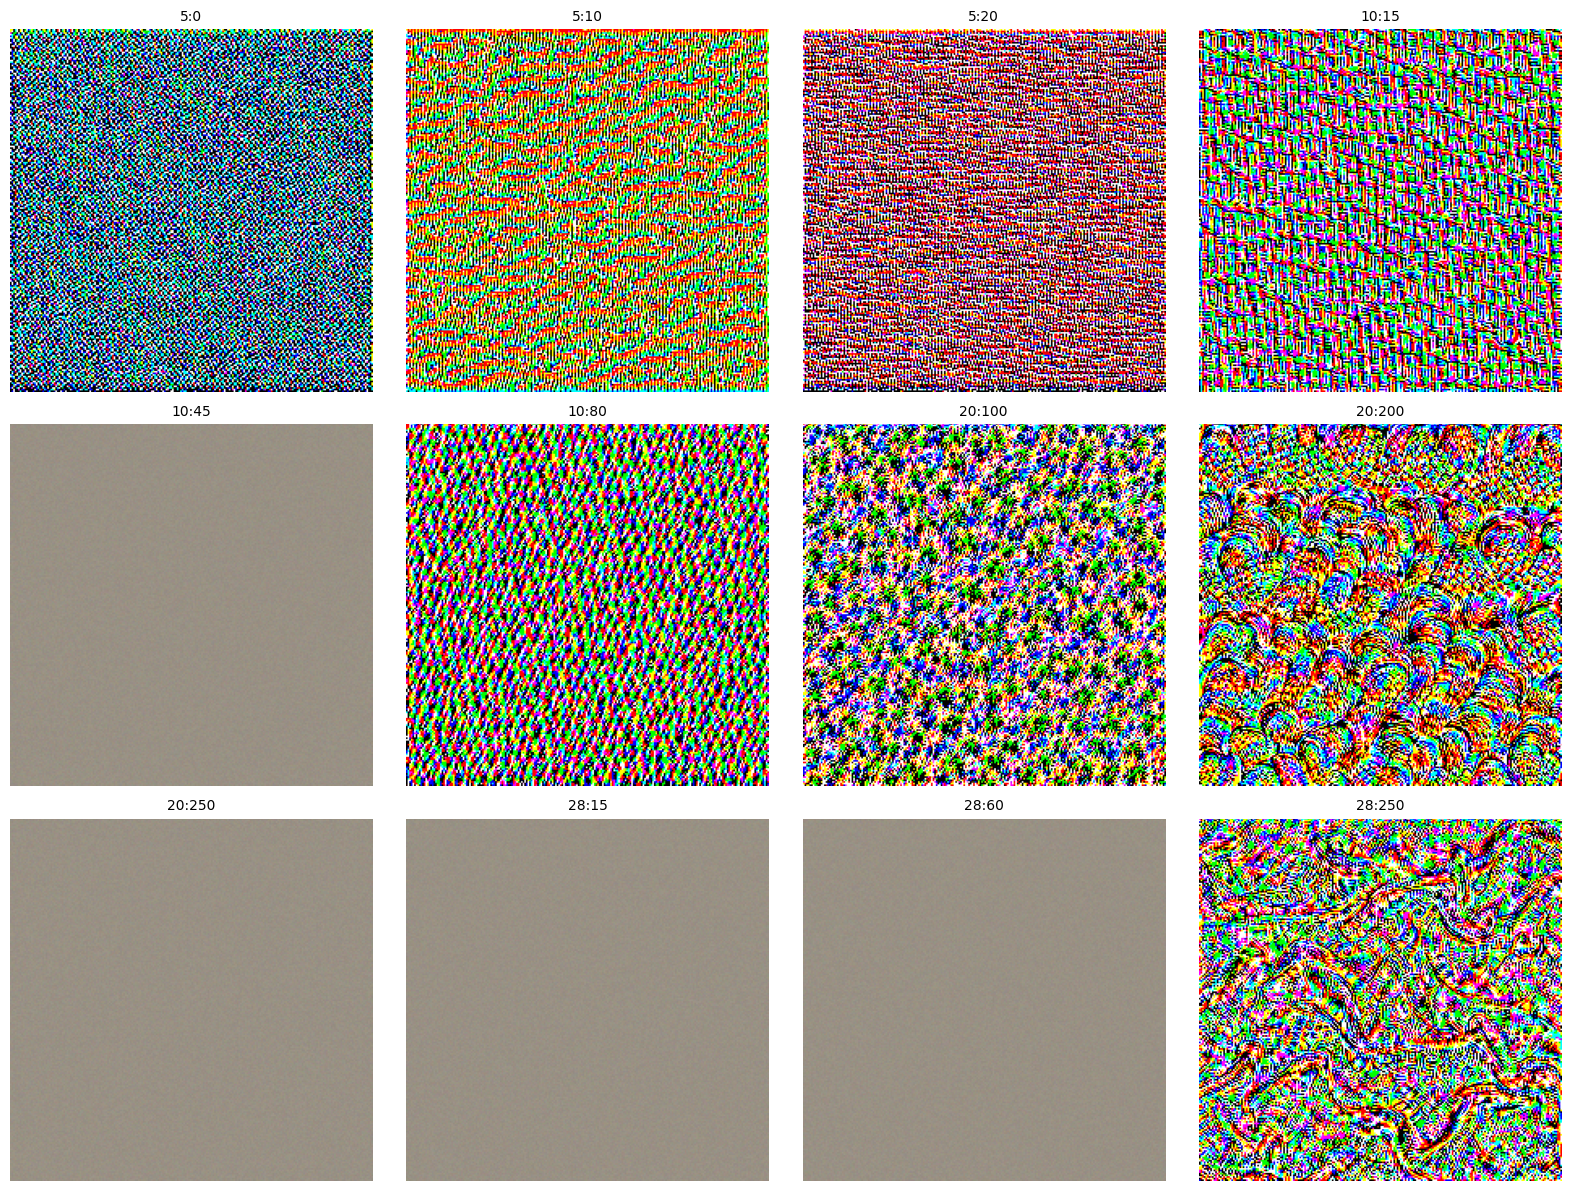

✓ Klart! Genererade 12 bilder med 500 iterationer var.


In [4]:
from src.activation_maximization import activation_maximization

# ===== PARAMETRAR FÖR ACTIVATION MAXIMIZATION =====
# Justera dessa värden för att ändra resultatet
ITERATIONS = 500  # Antal iterationer (500 = hög kvalitet, 100 = snabbt)
SAVE_PROGRESS = True  # Spara progression bilder

# Lager att testa (från tidigt till djupt)
layers_to_test = ['features.5', 'features.10', 'features.20', 'features.28']

# Filter per lager (välj vilka filter som ska visualiseras)
filters_per_layer = {
    'features.5': [0, 10, 20],      # Tidiga lager: enkla mönster
    'features.10': [15, 45, 80],    # Mellanlager: texturer
    'features.20': [100, 200, 250], # Djupare lager: komplexa former
    'features.28': [15, 60, 250]    # Sista lagret: semantiska delar
}

# ================================================

print(f"=== Activation Maximization med {ITERATIONS} iterationer ===")
am_results = []

for layer in layers_to_test:
    filters = filters_per_layer[layer]
    for f_idx in filters:
        print(f"Maximerar filter {f_idx} i {layer}...")
        # Spara progression för första filtret i varje lager
        save_prog = SAVE_PROGRESS and (f_idx == filters[0])
        
        try:
            am_img = activation_maximization(
                model, layer, f_idx, 
                iterations=ITERATIONS, 
                device=device,
                save_progress=save_prog,
                output_dir=f'../outputs/activation_max/{layer}'
            )
            am_results.append((layer, f_idx, am_img))
        except Exception as e:
            print(f"Fel vid AM på {device}: {e}, testar CPU...")
            am_img = activation_maximization(
                model.to('cpu'), layer, f_idx, 
                iterations=ITERATIONS, 
                device='cpu',
                save_progress=save_prog,
                output_dir=f'../outputs/activation_max/{layer}'
            )
            model.to(device)
            am_results.append((layer, f_idx, am_img))

# Visa alla resultat
print("\nVisar Activation Maximization resultat...")
num_results = len(am_results)
cols = 4
rows = (num_results + cols - 1) // cols

plt.figure(figsize=(16, 4 * rows))
for i, (layer, f_idx, img) in enumerate(am_results):
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title(f"{layer.split('.')[1]}:{f_idx}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.savefig('../outputs/activation_max/all_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Klart! Genererade {len(am_results)} bilder med {ITERATIONS} iterationer var.")

## 5. Sammanfattning och Slutsatser

**Vad har jag gjort?**
I denna laboration har jag arbetat med att öppna "den svarta lådan" för att få en djupare förståelse för hur Konvolutionella Neurala Nätverk (CNN) fungerar och fattar beslut. Jag har använt mig av biblioteket PyTorch och ett förtränat VGG16-nätverk för att utforska olika metoder inom Explainable AI (XAI).

1.  **Data & Modell**: Jag inledde med att ladda in och förbehandla bilddata för att passa VGG16-modellen. Detta inkluderade normalisering och storleksjustering av bilderna.

2.  **Feature Attribution (CAM)**: För G-delen implementerade jag Class Activation Mapping (CAM). Genom att plocka ut vikterna från det sista konvolutionella lagret kunde jag skapa heatmaps som visualiserar exakt var i bilden nätverket lägger sitt fokus. Jag noterade att modellen lyckades identifierade relevanta objekt, till exempel huvudet på en hund, vilket styrker att klassificeringen baseras på korrekta visuella attribut snarare än bakgrundsbrus.

3.  **Activation Maximization**: I VG-delen utforskade jag vad enskilda filter i nätverket "ser". Genom att använda gradient ascent på en brusbild (istället för att uppdatera vikterna) kunde jag visualisera de mönster som maximerar aktiveringen hos specifika filter. Jag noterade att det verkar finnas en tydlig hierarki: tidiga lager reagerar på enkla former som kanter och färger, medan djupare lager aktiveras av mer komplexa strukturer som ögon eller djurmönster. Jag använde även regularisering (L2 decay och Gaussian blur) för att göra bilderna mer visuellt tolkningsbara.

4.  **DeepDream**: Slutligen experimenterade jag med DeepDream för att det verkade intressant. Här lät jag nätverket "hallucinera" genom att förstärka de mönster det redan tyckte sig se i en befintlig bild. Resultatet blev överdrivna bilder där nätverkets tolkningar överdrevs, vilket gav en inblick i hur modellen tolkar former och texturer.

**Mina Slutsatser**
Genom laborationen har jag kunnat dra följande slutsatser:
-   **Hierarkisk Inlärning**: Det har blivit tydligt för mig att CNN lär sig hierarkiska representationer. Det blir mer komplext ju djupare in i nätverket man kommer.
-   **Vikten av Tolkbarhet**: Jag har insett att XAI-metoder som CAM och Activation Maximization är kraftfulla verktyg för att validera modeller. Att kunna se *varför* en modell tar ett beslut är avgörande för att upptäcka bias eller felaktig inlärning.
-   **Nätverkets "Fantasi"**: DeepDream-experimenten visade på ett intressant sätt hur nätverket är biased mot de mönster det tränats på (t.ex. att se hundansikten överallt om det tränats mycket på hundar).